In [112]:
from matplotlib import pyplot as plt

def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

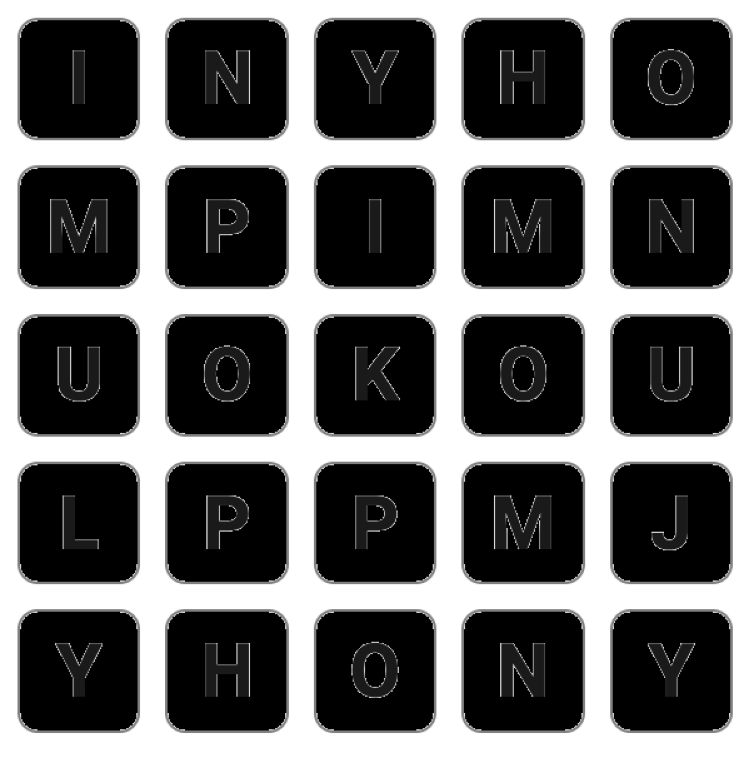

In [ ]:
import cv2
import importlib
import cleanSquardle
importlib.reload(cleanSquardle)


img = cv2.imread("/Users/sagewong/git/SquardleBot/temp/screen.png", 1)
cropped_image = img[706:1297, 2233:2816]
og_img = cropped_image.copy()
rows, cols, _ = cropped_image.shape
for i in range(rows):
        for j in range(cols):
            if (cropped_image[i, j] == [224, 224, 224]).any():
                cropped_image[i, j] = [0, 0, 0]
cv2.imwrite("temp/cropped_image.png", cropped_image)
display("/Users/sagewong/git/SquardleBot/temp/cropped_image.png")

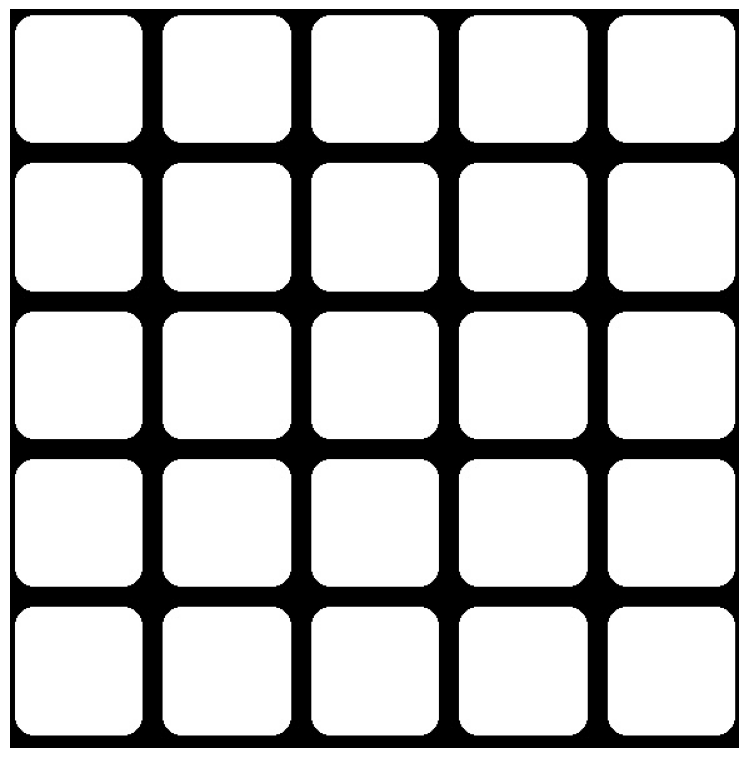

In [114]:
import numpy as np
kernel = np.ones((5, 5), np.uint8) 

blurred_image = cv2.erode(cropped_image, kernel)
inverse_image = cv2.bitwise_not(blurred_image)
thresh, threshed_img = cv2.threshold(inverse_image, 50, 255, cv2.THRESH_BINARY)

cv2.imwrite("temp/blurred_image.jpg", threshed_img)
display("temp/blurred_image.jpg")

In [158]:
import pytesseract
converted_img = cv2.cvtColor(threshed_img, cv2.COLOR_BGR2GRAY)
cnts = cv2.findContours(converted_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
sortedList = []

cnts = sorted(cnts, key=lambda x: (cv2.boundingRect(x)[0]))
antiPadding = 20
wordList = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    roi = cv2.copyMakeBorder(og_img[y+antiPadding:y+h-antiPadding, x+antiPadding:x+w-antiPadding], 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[224, 224, 224])
    wordList.append([pytesseract.image_to_string(roi, config="--psm 10"), x, y])
    cv2.imwrite("temp/index_roi.png", roi)
    cv2.rectangle(og_img, (x, y), (x+w, y+h), (36, 255, 12), 2)
cv2.imwrite("temp/index_bbox_new.png", og_img)

True

In [171]:
clusters = []
print(wordList)
for i in wordList:
    anyMatching = False
    for index, j in enumerate(clusters):
        if abs(j[0][0] - i[1]) < 10:
            clusters[index] = [[j[0][0]], j[1] + [i]]
            anyMatching = True
    if anyMatching == False:    
        clusters.append([[i[1]], [i]])
    if len(clusters) == 0:
        clusters.append([[i[1]], [i]])
print(clusters)

[['Y\n', 4, 478], ['L\n', 4, 360], ['U\n', 4, 242], ['M\n', 4, 123], ['|\n', 4, 5], ['H\n', 122, 478], ['P\n', 122, 360], ['O\n', 122, 242], ['P\n', 122, 123], ['N\n', 122, 5], ['@\n', 241, 478], ['P\n', 241, 360], ['K\n', 241, 242], ['|\n', 241, 123], ['Y\n', 241, 5], ['N\n', 359, 478], ['M\n', 359, 360], ['0\n', 359, 242], ['M\n', 359, 123], ['H\n', 359, 5], ['Y\n', 478, 478], ['J\n', 478, 360], ['U\n', 478, 242], ['N\n', 478, 123], ['O\n', 478, 5]]
[[[4], [['Y\n', 4, 478], ['L\n', 4, 360], ['U\n', 4, 242], ['M\n', 4, 123], ['|\n', 4, 5]]], [[122], [['H\n', 122, 478], ['P\n', 122, 360], ['O\n', 122, 242], ['P\n', 122, 123], ['N\n', 122, 5]]], [[241], [['@\n', 241, 478], ['P\n', 241, 360], ['K\n', 241, 242], ['|\n', 241, 123], ['Y\n', 241, 5]]], [[359], [['N\n', 359, 478], ['M\n', 359, 360], ['0\n', 359, 242], ['M\n', 359, 123], ['H\n', 359, 5]]], [[478], [['Y\n', 478, 478], ['J\n', 478, 360], ['U\n', 478, 242], ['N\n', 478, 123], ['O\n', 478, 5]]]]


In [172]:
newClusters = clusters.copy()
for index, i in enumerate(newClusters):
    newClusters[index][1] = sorted(newClusters[index][1], key=lambda x: x[2])


[[[4],
  [['|\n', 4, 5],
   ['M\n', 4, 123],
   ['U\n', 4, 242],
   ['L\n', 4, 360],
   ['Y\n', 4, 478]]],
 [[122],
  [['N\n', 122, 5],
   ['P\n', 122, 123],
   ['O\n', 122, 242],
   ['P\n', 122, 360],
   ['H\n', 122, 478]]],
 [[241],
  [['Y\n', 241, 5],
   ['|\n', 241, 123],
   ['K\n', 241, 242],
   ['P\n', 241, 360],
   ['@\n', 241, 478]]],
 [[359],
  [['H\n', 359, 5],
   ['M\n', 359, 123],
   ['0\n', 359, 242],
   ['M\n', 359, 360],
   ['N\n', 359, 478]]],
 [[478],
  [['O\n', 478, 5],
   ['N\n', 478, 123],
   ['U\n', 478, 242],
   ['J\n', 478, 360],
   ['Y\n', 478, 478]]]]

In [179]:
newNewClusters = []
for i in newClusters:
    newNewClusters.append(i[1])
newNewClusters

[[['|\n', 4, 5],
  ['M\n', 4, 123],
  ['U\n', 4, 242],
  ['L\n', 4, 360],
  ['Y\n', 4, 478]],
 [['N\n', 122, 5],
  ['P\n', 122, 123],
  ['O\n', 122, 242],
  ['P\n', 122, 360],
  ['H\n', 122, 478]],
 [['Y\n', 241, 5],
  ['|\n', 241, 123],
  ['K\n', 241, 242],
  ['P\n', 241, 360],
  ['@\n', 241, 478]],
 [['H\n', 359, 5],
  ['M\n', 359, 123],
  ['0\n', 359, 242],
  ['M\n', 359, 360],
  ['N\n', 359, 478]],
 [['O\n', 478, 5],
  ['N\n', 478, 123],
  ['U\n', 478, 242],
  ['J\n', 478, 360],
  ['Y\n', 478, 478]]]

In [195]:
length = len(newNewClusters[0])
newestList = [[] for i in range(len(newNewClusters[0]))]
for j in range(length):
    for i in newNewClusters:
        newestList[j] = newestList[j] + [i[j][0].replace("\n", "").replace("|", "I").replace("0", "O").replace("@", "O"), i[j][1], i[j][2]]
newestList


[['I', 4, 5, 'N', 122, 5, 'Y', 241, 5, 'H', 359, 5, 'O', 478, 5],
 ['M', 4, 123, 'P', 122, 123, 'I', 241, 123, 'M', 359, 123, 'N', 478, 123],
 ['U', 4, 242, 'O', 122, 242, 'K', 241, 242, 'O', 359, 242, 'U', 478, 242],
 ['L', 4, 360, 'P', 122, 360, 'P', 241, 360, 'M', 359, 360, 'J', 478, 360],
 ['Y', 4, 478, 'H', 122, 478, 'O', 241, 478, 'N', 359, 478, 'Y', 478, 478]]